In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
FIG_PATH = Path('./figures/1DGP_figures')
FIG_PATH.mkdir(exist_ok=True)

DATASET_PATH = Path('./dataset.nosync')
DATASET_PATH.mkdir(exist_ok=True)

In [3]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [4]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400
  
@dataclass
class Args:  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int =  500_000 # 500_000
  eval_frequency: int = 1000
  learning_rate: float = 1e-3
  beta: float = 1e-2  # beta-VAE
  
  # Model params
  hidden_gnn_dim: int = 3
  hidden_fc_dim: int = 35
  latent_dim: int = 30
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP1D_ARGS = GP1DArgs()
ARGS = Args()

In [5]:
model_name = (
    f'PriorVGAE_1DGP_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}_'
    f'numLocations{GP1D_ARGS.num_locations}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\beta = {ARGS.beta}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    f'\n num_loc = {GP1D_ARGS.num_locations}'
    ')'
)

print(model_name)

PriorVGAE_1DGP_lr0.001_epochs500000_beta0.01_gnn3_fc35_z30_numLocations400


# Dataset: GP priors to be encoded

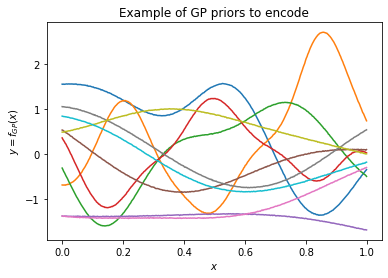

In [6]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)

num_to_plot = 10
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP1D_ARGS.kernel)

plotting.plot_gp_draws(
    X, gp_draws,
    num_draws_to_plot=num_to_plot,
    title='Example of GP priors to encode', 
    x_label='$x$', 
    y_label='$y=f_{GP}(x)$',
)

# Building the model

In [7]:
data_filepath = DATASET_PATH / f'1DGP_numLoc{GP1D_ARGS.num_locations}_1M_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 1_000_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from dataset.nosync/1DGP_numLoc400_1M_train_data.npy


In [8]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]

train_size_limit = 940_000
val_size = 2010  # + 1000 for the final epoch evaluation and batching

# train_data = data[:train_size_limit]
train_data = data[:]
val_data = data[train_size_limit:train_size_limit+val_size]

In [9]:
print(train_data.shape)
print(val_data.shape)

(947740, 400)
(2010, 400)


In [10]:
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

graph_train_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in train_data]
graph_val_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in val_data]

Comment: Removing linear (hidden_fc) before latent hidden layer makes samples even NOISIER

In [11]:
from functools import partial
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self.act
        )

        return VGAEOutput(mean, log_std, output)


def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=False,
    )
    graph = gn(graph)
    
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=False,
    )
    graph = gn(graph)
    
    # Fully-connected layer
    x = graph.nodes.reshape(1, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (1, num_nodes*hidden_gnn_dim)
    
    x = hk.Linear(hidden_fc_dim)(x)
    x = act_fn(x)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(hidden_fc_dim, name='decoder_hidden1')(z)
    z = act_fn(z)
    
    z = hk.Linear(hidden_fc_dim, name='decoder_hidden1')(z)
    z = act_fn(z)
    
    # # Graph normalization
    # NOTE :- Graph normalization on the decoder yields a shrinked GP.
    # # graph = layer.GraphwiseLayerNorm()(graph)
    
    # # No activation
    # gn = layer.GraphConvolutionSharpening(
    #     update_node_fn=hk.Linear(output_dim, name='decoder_output'),
    #     add_self_edges=False,
    # )
    # graph = gn(graph)

    z = hk.Linear(num_nodes, name='decoder_output')(z)
    graph = BASE_GRAPH._replace(nodes=z.T)

    return graph

In [12]:
extend_model_params_title = True
    
extension_string = 'using_GAT = False, add_self_edges = True'

if extend_model_params_title:
    model_params_title = model_params_title[:-1] + ', ' + extension_string

# Training time

In [13]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 num_nodes=GP1D_ARGS.num_locations)(x))

## Training optimizer

In [14]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

### Loss function and update

In [15]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = (1.0/ARGS.beta)*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

### Initialize net and optimizer

In [16]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [17]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

train_size = len(graph_train_data)
val_size = len(graph_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = graph_train_data[epoch % train_size]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = graph_val_data[eval_counter]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_klds.append(train_kld.item())
    val_klds.append(val_kld.item())
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x1692d70d0>
22:08:53 STEP: 0; Train loss: 95.405; Validation loss: 87.274; 
22:08:54 STEP: 1000; Train loss: 15.987; Validation loss: 19.249; 
22:08:54 STEP: 2000; Train loss: 14.927; Validation loss: 24.382; 
22:08:54 STEP: 3000; Train loss: 18.367; Validation loss: 27.070; 
22:08:55 STEP: 4000; Train loss: 11.592; Validation loss: 10.351; 
22:08:55 STEP: 5000; Train loss: 12.149; Validation loss: 14.009; 
22:08:55 STEP: 6000; Train loss: 8.048; Validation loss: 23.687; 
22:08:56 STEP: 7000; Train loss: 8.248; Validation loss: 13.960; 
22:08:56 STEP: 8000; Train loss: 26.566; Validation loss: 25.744; 
22:08:57 STEP: 9000; Train loss: 7.903; Validation loss: 13.842; 
22:08:57 STEP: 10000; Train loss: 7.837; Validation loss: 11.406; 
22:08:57 STEP: 11000; Train loss: 20.246; Validation loss: 24.670; 
22:08:58 STEP: 12000; Train loss: 16.566; Validation loss: 11.050; 
22:08:58 STEP: 13000; Train loss: 14.871; Validation loss: 64.298; 
22:08:59 STEP:

In [18]:
print(eval_counter)

501


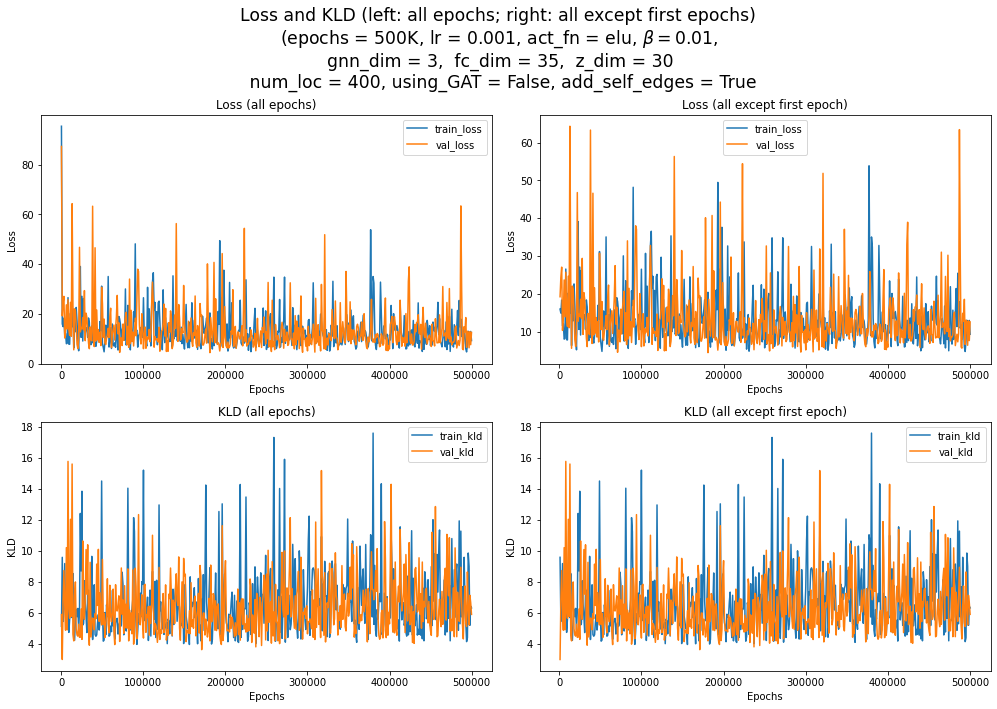

In [19]:
from matplotlib.ticker import MaxNLocator

# Loss plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0, 0].plot(xs, train_losses, label='train_loss')
axes[0, 0].plot(xs, val_losses, label='val_loss')
axes[0, 1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[0, 1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0, 0].set_title('Loss (all epochs)')
axes[0, 1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_xlabel('Epochs')
    axes[0, i].legend()
    
# KLD plots
xs = np.arange(len(train_klds))*ARGS.eval_frequency
axes[1, 0].plot(xs, train_klds, label='train_kld')
axes[1, 0].plot(xs, val_klds, label='val_kld')
axes[1, 1].plot(xs[1:], train_klds[1:], label='train_kld')
axes[1, 1].plot(xs[1:], val_klds[1:], label='val_kld')
axes[1, 0].set_title('KLD (all epochs)')
axes[1, 1].set_title('KLD (all except first epoch)')

for i in range(2): 
    axes[1, i].set_ylabel('KLD')
    axes[1, i].set_xlabel('Epochs')
    axes[1, i].legend()

fig.suptitle(f'Loss and KLD (left: all epochs; right: all except first epochs) \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

loss_kld_path = FIG_PATH / 'loss_kld_figures'
loss_kld_path.mkdir(exist_ok=True)
fig.savefig(loss_kld_path / f'{model_name}.jpg', dpi=300)

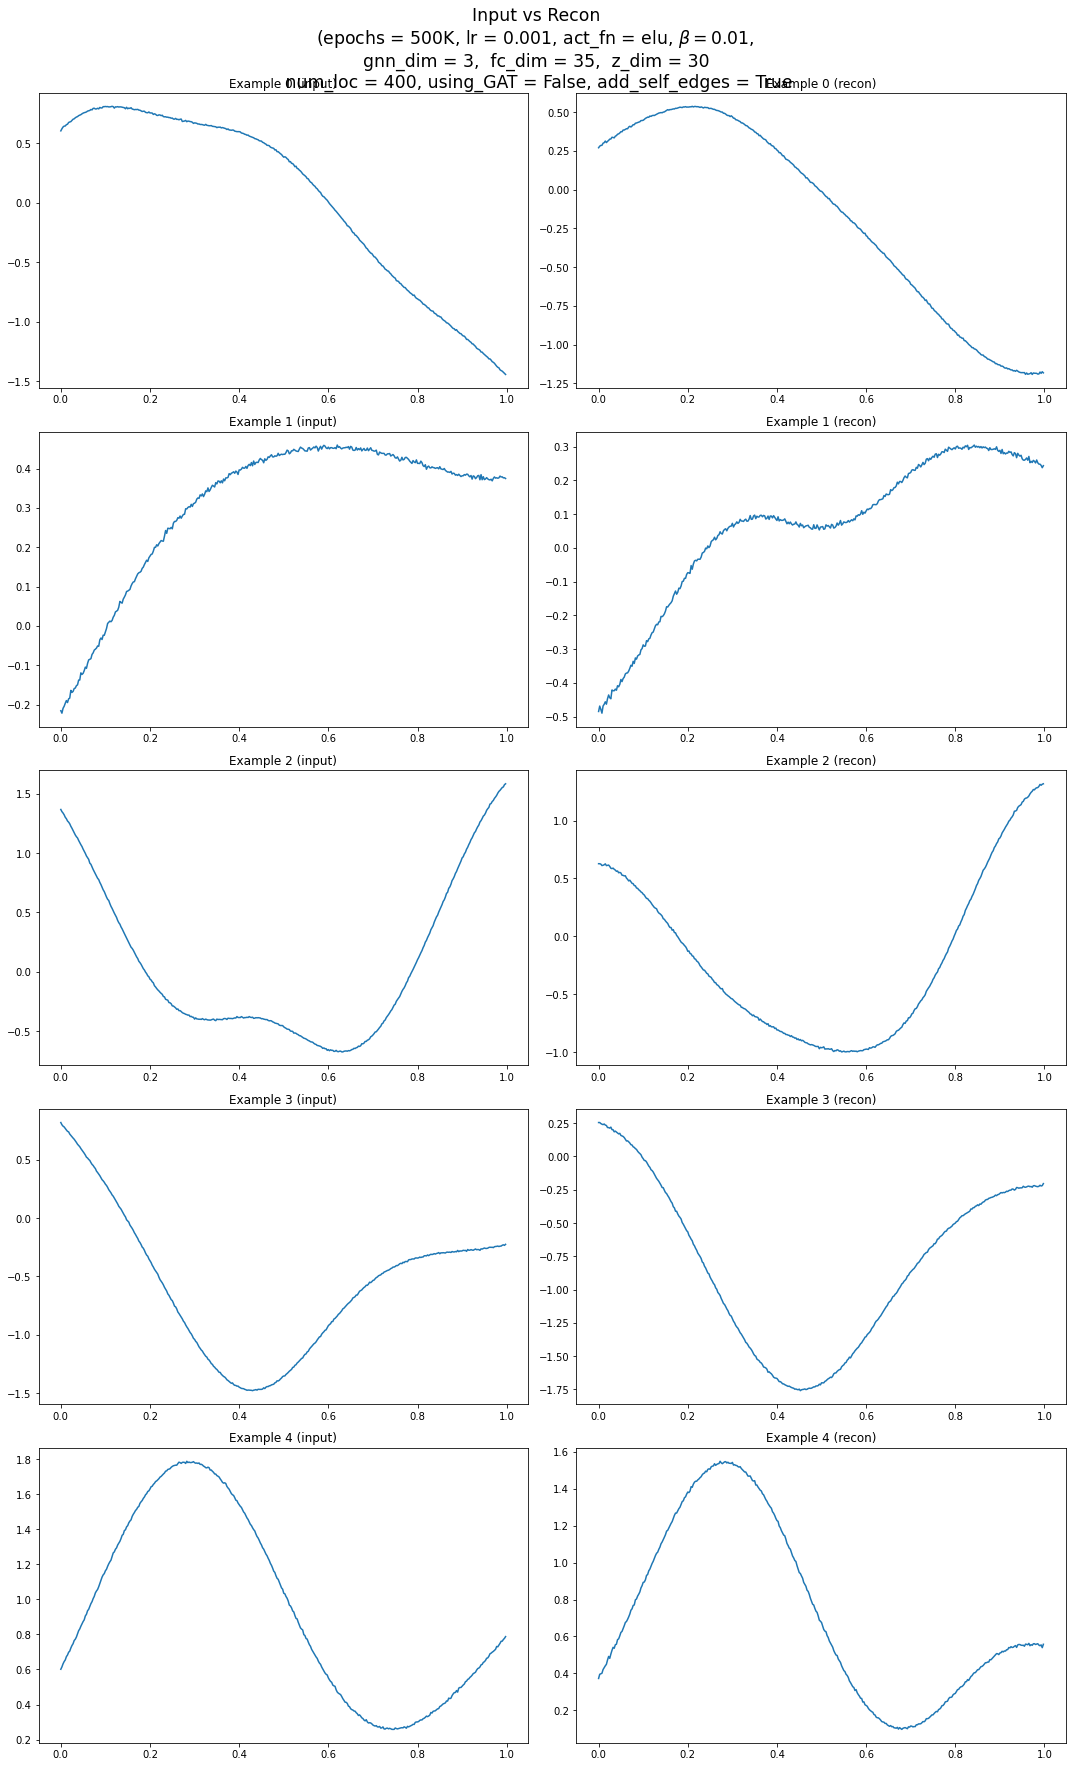

In [20]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

num_to_plot = 5
fig, axes = plt.subplots(num_to_plot, 2, figsize=(15, 25))

for i in range(num_to_plot):
    original_data = val_data[i]
    graph_data = graph_val_data[i]
    
    outputs = net.apply(params, RNG_KEY, graph_data)
    recon_data = outputs.output.nodes.T

    original_gp = jnp.ravel(original_data)
    recon_gp = jnp.ravel(recon_data)

    axes[i, 0].plot(X, original_gp)
    axes[i, 1].plot(X, recon_gp)
    
    axes[i, 0].set_title(f'Example {i} (input)')
    axes[i, 1].set_title(f'Example {i} (recon)')

fig.suptitle(f'Input vs Recon\n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

input_v_recon_path = FIG_PATH / 'recon_figures'
input_v_recon_path.mkdir(exist_ok=True)
fig.savefig(input_v_recon_path / f'{model_name}.jpg', dpi=300)

In [21]:
from functools import partial

decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
decoder_params = {}
for full_key_name in decoder_params_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    decoder_params[key_name] = params[full_key_name]
    
GP1D_ARGS.decoder_params = decoder_params

decoder_net_fn = partial(decoder,
                         hidden_fc_dim=ARGS.hidden_fc_dim,
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         num_nodes=GP1D_ARGS.num_locations)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [22]:
def decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z).nodes)
    numpyro.deterministic('f', vgae_out)

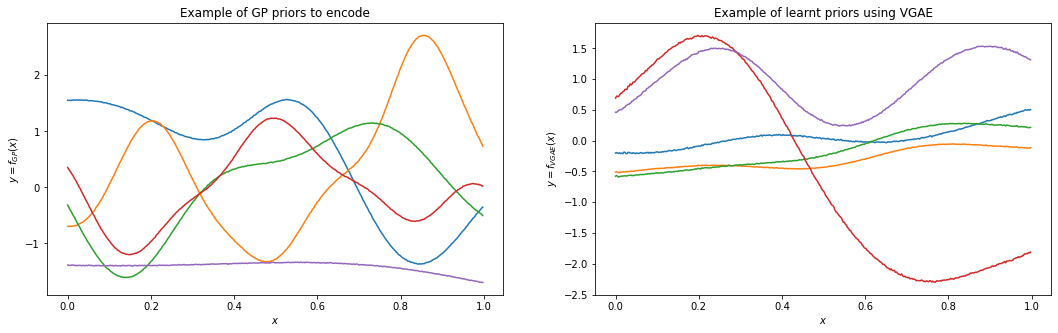

In [23]:
# Rough comparison of the shape of GP draws with learnt VGAE priors.

# Drawing VGAE priors.
RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)
vgae_draws = Predictive(
  decoder_predictive_model, num_samples=10)(vgae_sample_rng)['f']

# Plotting the GP draws and VGAE draws.
_, ax = plt.subplots(1, 2, figsize=(18, 5))

plotting.plot_gp_draws(X, gp_draws, num_draws_to_plot=5, 
                     ax=ax[0], title='Example of GP priors to encode', y_label='$y=f_{GP}(x)$')

plotting.plot_gp_draws(X, vgae_draws, num_draws_to_plot=5, 
                     ax=ax[1], title='Example of learnt priors using VGAE', y_label='$y=f_{VGAE}(x)$', )

plt.show()

In [24]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples)(vgae_rng)['f']

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

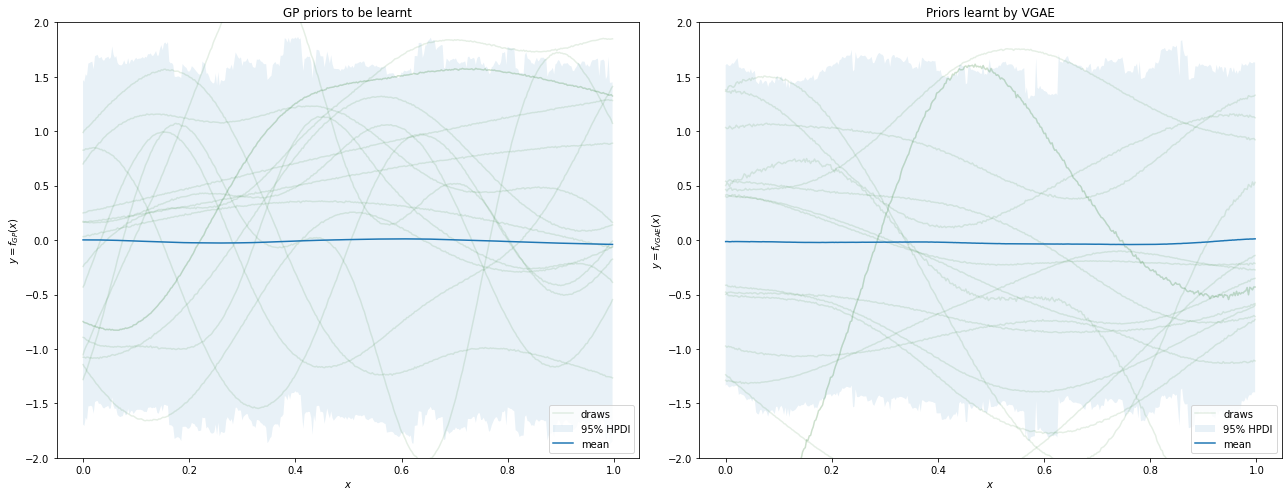

In [25]:

# Plotting the GP draws and VGAE draws.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to be learnt', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, mean_vgae, hpdi_vgae,
    lines_alpha_vgae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='Priors learnt by VGAE',
    y_label=r'$y=f_{VGAE}(x)$')

# fig.suptitle(f'GP Priors vs Learnt VGAE Priors \n{model_params_title}', fontsize='xx-large')
# fig.suptitle(f'GP Priors vs Learnt VGAE Priors', fontsize='xx-large')

plt.tight_layout()
plt.show()

estimate_plot_path = FIG_PATH / 'estimate_figures'  
estimate_plot_path.mkdir(exist_ok=True)
fig.savefig(estimate_plot_path / f'{model_name}.jpg', dpi=300)

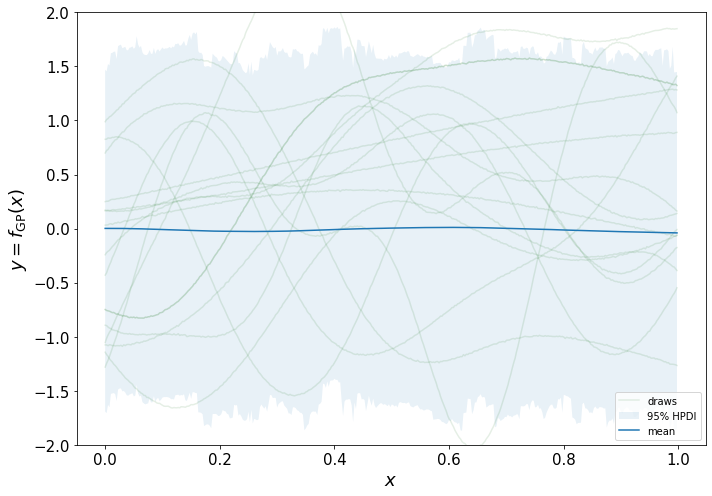

In [26]:
# Plotting the GP draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('GP priors to be learnt', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{GP}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
save_to_dir.mkdir(exist_ok=True)
fig.savefig(save_to_dir / '1DGP_priors_GP.jpg', dpi=300)

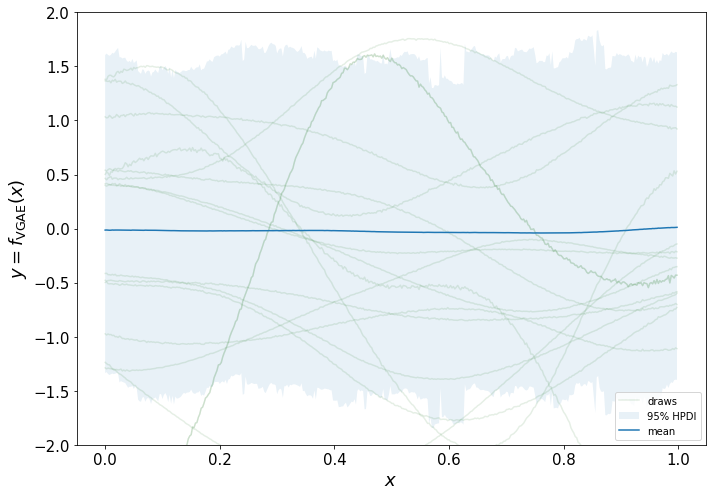

In [27]:
# Plotting the GP draws and VGAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, 
    mean_vgae, hpdi_vgae,lines_alpha_vgae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VGAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VGAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_priors_VGAE.jpg', dpi=300)

In [28]:
# assert False, 'Inference is turned off'

# Inference on Observed Data

In [29]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z).nodes)
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

## Ground truth and observed data

In [30]:
RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# Choose indices of datapoints for inference.
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([71, 85, 111, 291, 314, 380]),  # 6 observed datapoints
# ]
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([71, 85, 147, 291, 314, 380]),  # 6 observed datapoints
# ]
obs_locations = [
  jnp.array([122, 321]),  # 2 observed datapoints
  jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 147, 275, 314, 380]),  # 6 observed datapoints
]

In [31]:
mean_post_preds_list = []
hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []
mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgae_mcmc_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    mcmc_objs.append(mcmc)

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1720.69it/s, 31 steps of size 9.54e-02. acc. prob=0.80]



MCMC elapsed time: 7.826901197433472


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1474.54it/s, 127 steps of size 3.01e-02. acc. prob=0.93]



MCMC elapsed time: 6.704188346862793


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2024.48it/s, 15 steps of size 2.94e-01. acc. prob=0.91]



MCMC elapsed time: 5.755873203277588


In [32]:
def compute_ess(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all effects : " + str(round(r)))
    
for mcmc in mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 1400
Average ESS for all effects : 653
Average ESS for all effects : 3717


In [33]:
mcmc_objs[-1].print_summary(exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.64      0.43     -1.65     -2.38     -0.98   2487.08      1.00
      f[1]     -1.66      0.43     -1.66     -2.39     -1.00   2482.99      1.00
      f[2]     -1.67      0.43     -1.67     -2.41     -1.01   2480.53      1.00
      f[3]     -1.65      0.43     -1.66     -2.39     -1.00   2485.65      1.00
      f[4]     -1.70      0.43     -1.70     -2.41     -1.03   2475.24      1.00
      f[5]     -1.69      0.43     -1.69     -2.42     -1.04   2479.58      1.00
      f[6]     -1.71      0.43     -1.71     -2.43     -1.06   2475.13      1.00
      f[7]     -1.69      0.42     -1.69     -2.40     -1.05   2480.10      1.00
      f[8]     -1.71      0.42     -1.71     -2.42     -1.07   2472.64      1.00
      f[9]     -1.72      0.42     -1.72     -2.44     -1.09   2470.47      1.00
     f[10]     -1.71      0.41     -1.71     -2.40     -1.08   2474.75      1.00
     f[11]     -1.70      0

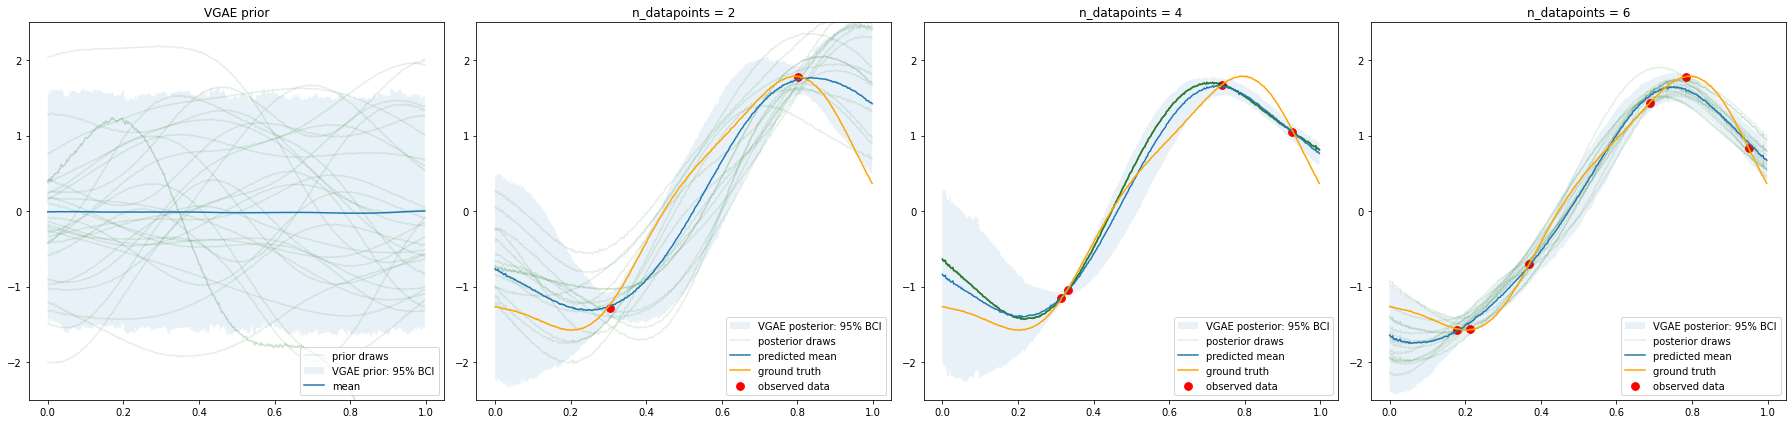

In [34]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VGAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VGAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VGAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

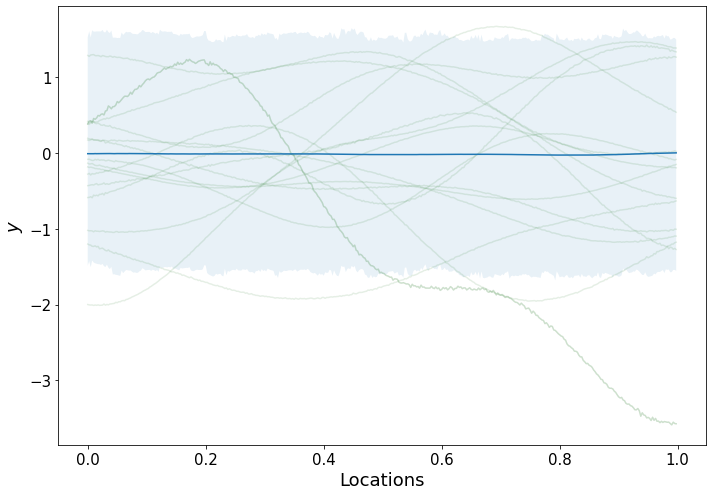

In [35]:
# Plotting results after inference using MCMC.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    ax.plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
ax.plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
ax.fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
ax.plot(X, mean_prior_pred, label='mean')
# ax.set_title('VAE prior')

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show();

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_inference_1.jpg', dpi=300)

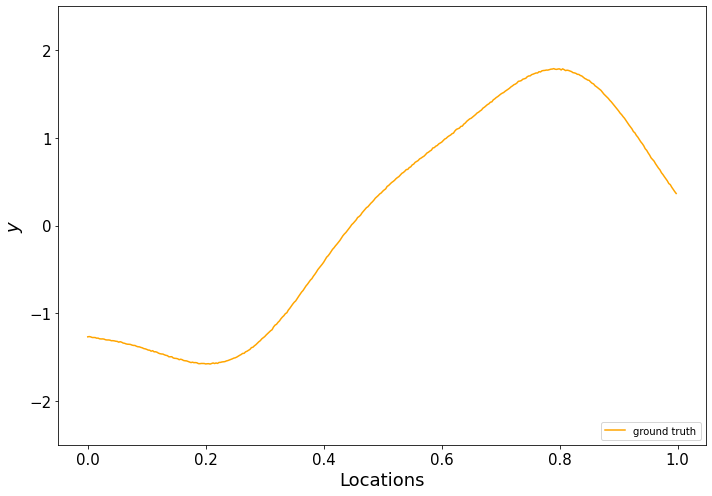

In [36]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(X, gp_draw, label='ground truth', color='orange')
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / f'1DGP_inference_00.jpg', dpi=300)

n_datapoints = 2


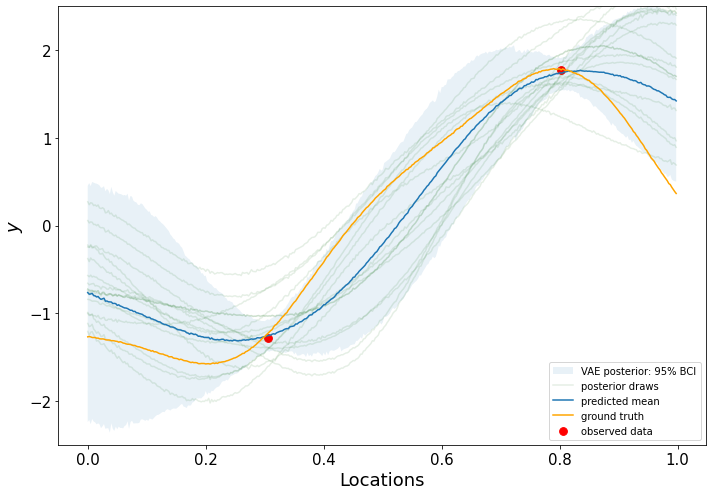

n_datapoints = 4


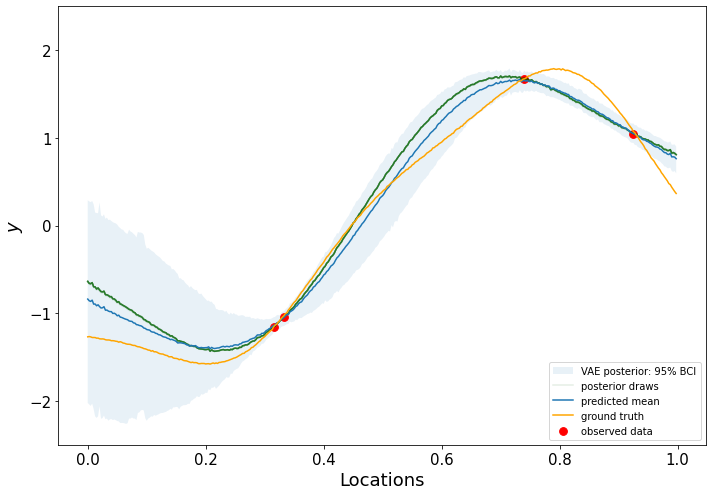

n_datapoints = 6


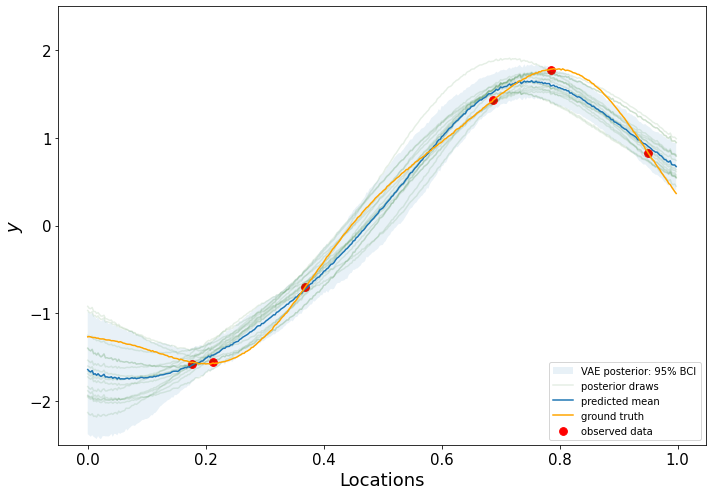

In [37]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    ax.fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_xlabel('Locations', fontsize=18)
    ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    plt.tight_layout()
    plt.show()
    
    save_to_dir = FIG_PATH / 'publication'
    fig.savefig(save_to_dir / f'1DGP_inference_{idx+2}.jpg', dpi=300)

In [38]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (2) = 0.1667625457048416
mse_vgae (4) = 0.039250448346138
mse_vgae (6) = 0.037403710186481476


Text(0.5, 1.0, 'VGAE covariance matrix')

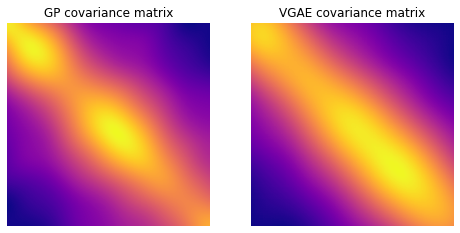

In [39]:
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(44), 3)
RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(6), 3)
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(16), 3)

gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=100)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

vgae_predictive = Predictive(vgae_mcmc_predictive_model, num_samples=100)
vgae_draws = vgae_predictive(vgae_rng)['f']
vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)

m_vgae = np.cov(np.transpose(vgae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vgae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VGAE covariance matrix')

## Priors learnt by VAE

In [40]:
vae_model_name = '1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize'
model_path = Path('./models/') / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VAE model from models/1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize


In [41]:
vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=50,
        hidden2_dim=50,
        output_dim=GP1D_ARGS.num_locations
    )
))

def vae_decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([30]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    numpyro.deterministic('f', vae_out)

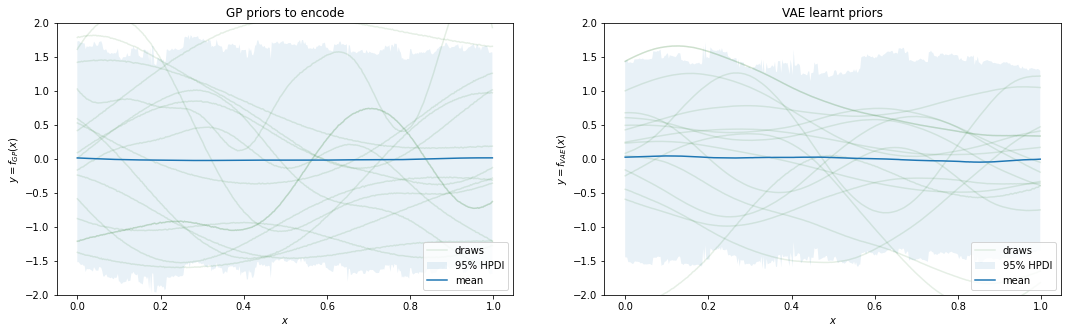

In [42]:
# Comparing distribution of GP draws with learnt VAE priors.

RNG_KEY, rng_gp, rng_vae = jax.random.split(RNG_KEY, 3)
gp_draws = dataset_1dgp.generate_gp_batch(
    rng_gp, X, batch_size=1000, kernel=GP1D_ARGS.kernel)  # batch_size is equivalent to `num_samples`.
vae_draws = Predictive(vae_decoder_predictive_model, num_samples=1000)(rng_vae)['f']

# Computing the mean and HPDI of the GP draws and VAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vae_draws = vae_draws[~np.isnan(vae_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

# Plotting the GP draws and VAE draws.
_, axes = plt.subplots(1, 2, figsize=(18, 5))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vae_draws, mean_vae, hpdi_vae,
    lines_alpha_vae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VAE learnt priors', y_label='$y=f_{VAE}(x)$')

plt.show()

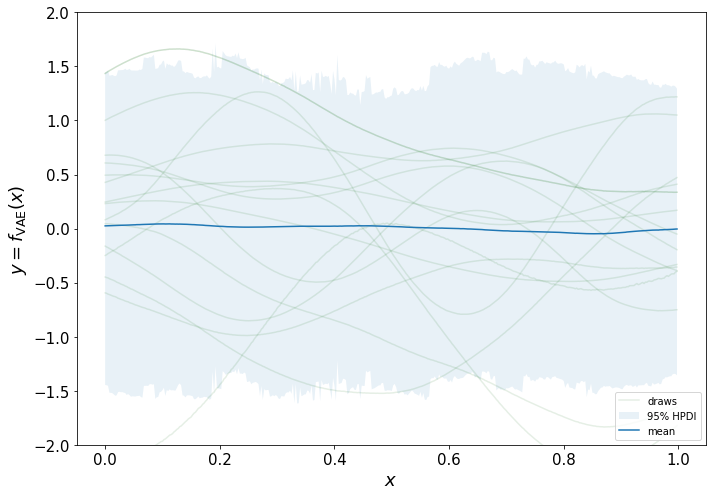

In [43]:
# Plotting the GP draws and VAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vae_draws, 
    mean_vae, hpdi_vae,lines_alpha_vae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_priors_VAE.jpg', dpi=300)

In [44]:
def vae_model_mcmc(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([30]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [45]:
vae_mean_post_preds_list = []
vae_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []
vae_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vae_model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vae_mcmc_objs.append(mcmc)

    predictions = Predictive(vae_model_mcmc, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2019.40it/s, 31 steps of size 1.29e-01. acc. prob=0.72]



MCMC elapsed time: 6.090632915496826


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1789.97it/s, 63 steps of size 5.82e-02. acc. prob=0.89]



MCMC elapsed time: 6.118376016616821


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_17490/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2318.17it/s, 7 steps of size 4.09e-01. acc. prob=0.89] 



MCMC elapsed time: 5.200553894042969


In [46]:
for mcmc in vae_mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 1833
Average ESS for all effects : 1922
Average ESS for all effects : 3465


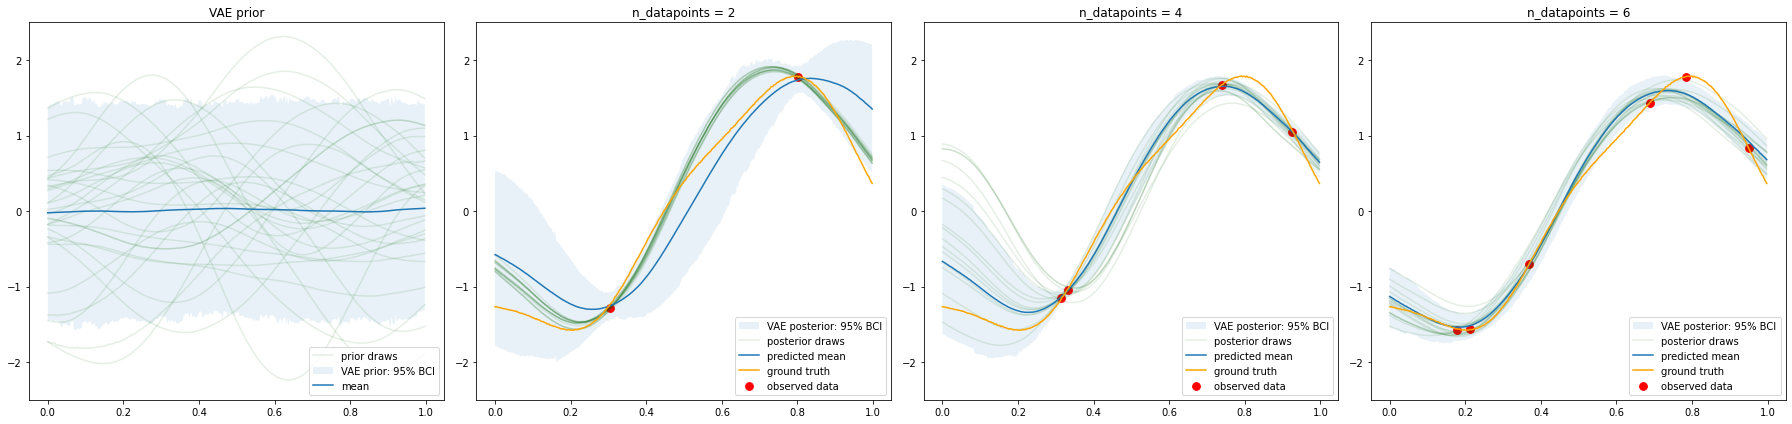

In [47]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

n_datapoints = 2


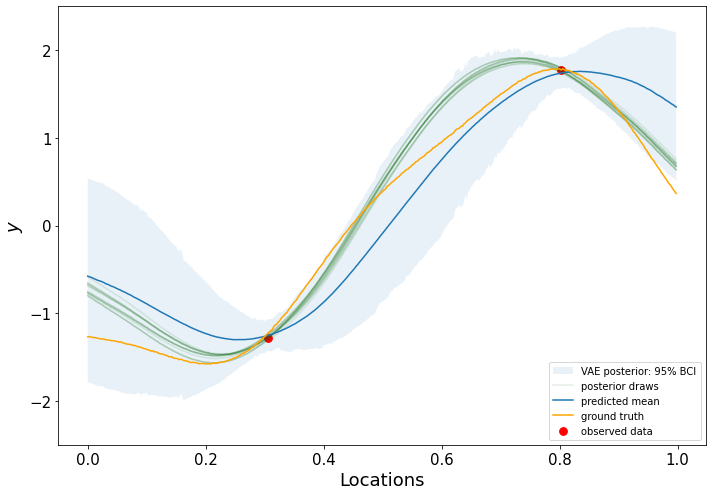

n_datapoints = 4


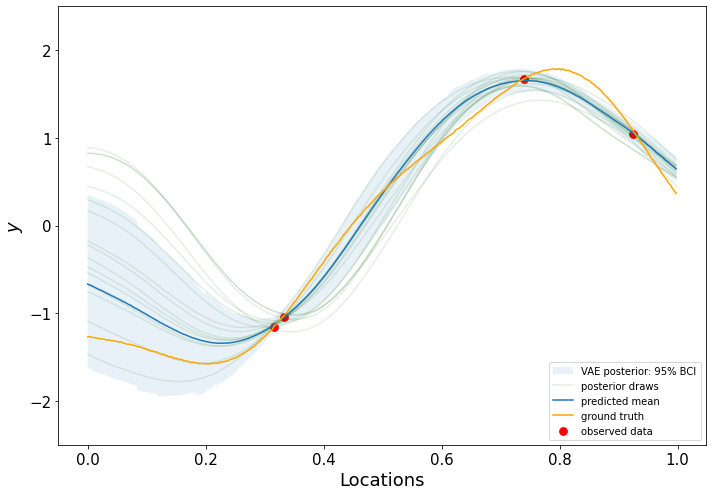

n_datapoints = 6


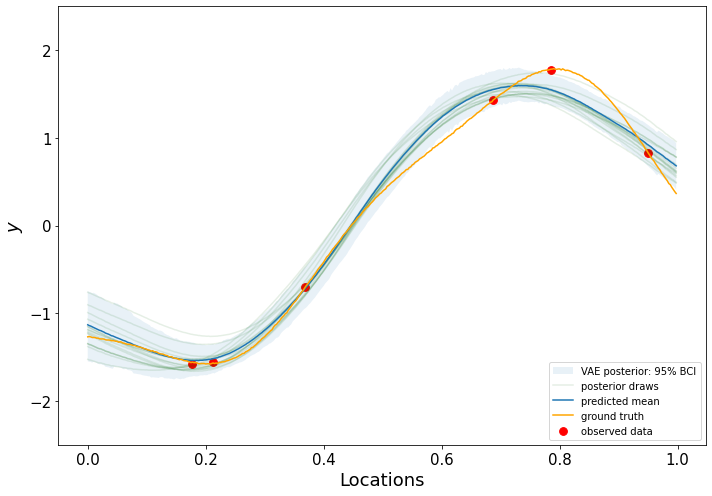

In [48]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    ax.fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_xlabel('Locations', fontsize=18)
    ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    plt.tight_layout()
    plt.show()
    
    save_to_dir = FIG_PATH / 'publication'
    fig.savefig(save_to_dir / f'1DGP_inference_PriorVAE_{idx+2}.jpg', dpi=300)

## Both plots

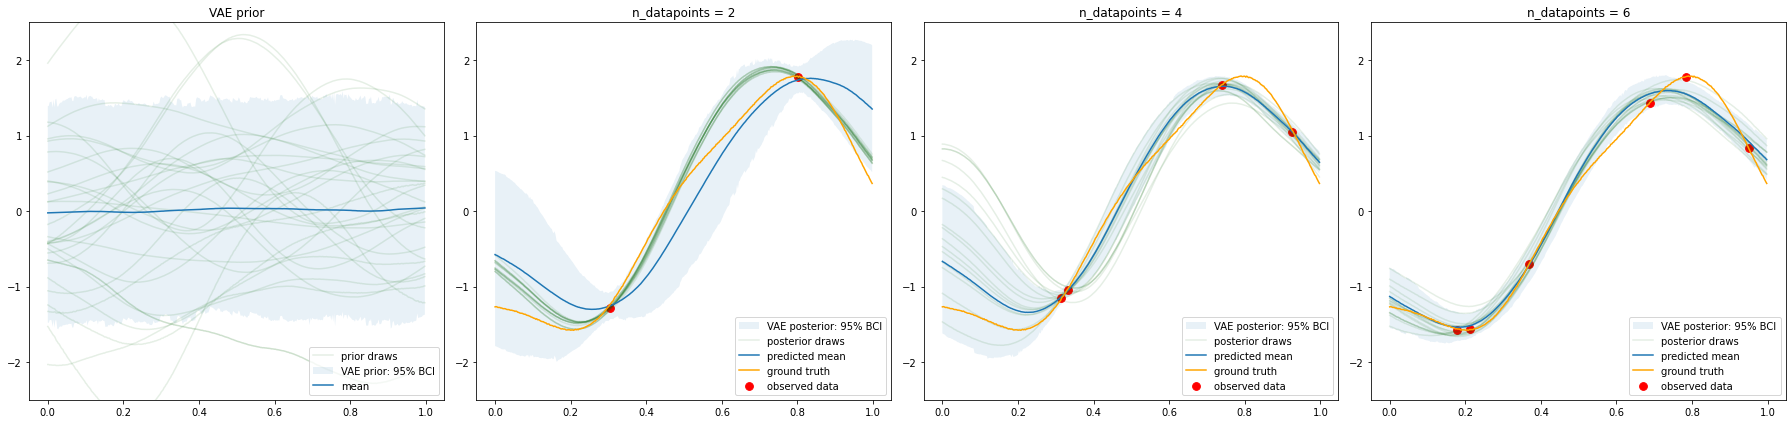

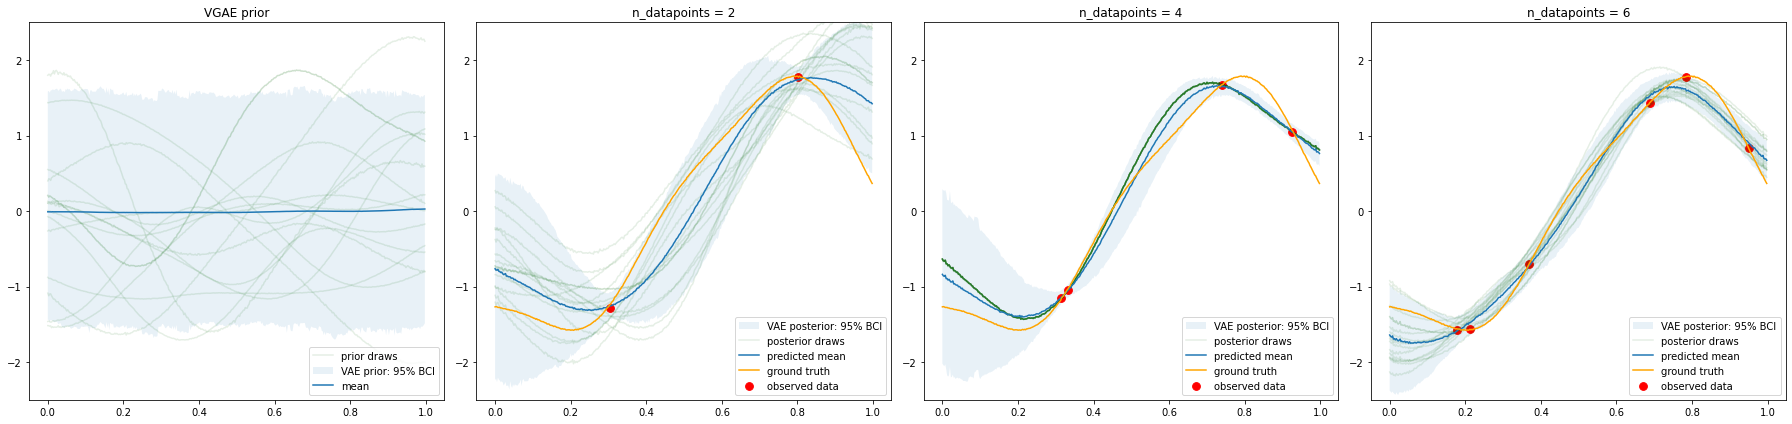

In [49]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

In [50]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (2) = 0.1667625457048416
mse_vgae (4) = 0.039250448346138
mse_vgae (6) = 0.037403710186481476


In [51]:
for idx, mean in enumerate(vae_mean_post_preds_list):
    mse_vae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mse_vae}')

mse_vae (2) = 0.166422501206398
mse_vae (4) = 0.05720733106136322
mse_vae (6) = 0.023716256022453308


In [52]:
mean_post_pred_vae = vae_mean_post_preds_list[-1]
mean_post_pred_vgae = mean_post_preds_list[-1]

mse_vgae = np.mean((gp_draw.flatten() -  mean_post_pred_vgae)**2)
mse_vae = np.mean((gp_draw.flatten() -  mean_post_pred_vae)**2)
print(f'mse_vgae = {mse_vgae}')
print(f'mse_vae = {mse_vae}')

mse_vgae = 0.037403710186481476
mse_vae = 0.023716256022453308


mse_vgae_encoderGraphNorm = 0.03129349276423454

mse_vgae = 0.014667835086584091

mse_vae = 0.023716256022453308

compute mse vgae when using GraphNormalization and see if it reduces, put in table.